# Import

In [242]:
import os
import copy
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem

import scipy
from sklearn import metrics
from ase.units import Hartree, mol, kcal, kJ

from IPython.core.display import display
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True  # Change output to SVG
IPythonConsole.drawOptions.addAtomIndices = True

In [243]:
# config
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({'font.size': 22})

# Change Matplotlib font to Helvetica
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib.legend_handler import HandlerTuple

mpl.rcParams['font.family'] = 'Helvetica'
fm.findfont("Helvetica", fontext="ttx", rebuild_if_missing=False)

'/System/Library/Fonts/Helvetica.ttc'

In [244]:
import py3Dmol
def draw3d(
    mols,
    width=400,
    height=400,
    Hs=True,
    confId=-1,
    multipleConfs=False,
    atomlabel=False,
):
    try:
        p = py3Dmol.view(width=width, height=height)
        if type(mols) is not list:
            mols = [mols]
        for mol in mols:
            if multipleConfs:
                for conf in mol.GetConformers():
                    mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
                    p.addModel(mb, "sdf")
            else:
                if type(mol) is str:
                    if os.path.splitext(mol)[-1] == ".xyz":
                        xyz_f = open(mol)
                        line = xyz_f.read()
                        xyz_f.close()
                        p.addModel(line, "xyz")
                else:
                    mb = Chem.MolToMolBlock(mol, confId=confId)
                    p.addModel(mb, "sdf")
        p.setStyle({"sphere": {"radius": 0.4}, "stick": {}})
        if atomlabel:
            p.addPropertyLabels("index")  # ,{'elem':'H'}
        p.zoomTo()
        p.update()
        # p.show()
    except:
        print("py3Dmol, RDKit, and IPython are required for this feature.")

# Modify covalentinhibtors.csv

In [245]:
df = pd.read_csv('../from_sources/covalentinhibtors.csv', sep=',', encoding= 'unicode_escape')

In [246]:
df.head(2)

,smiles,name,Delta_G_ts,omega_ground_state,omega_transition_state
0,[H]N(C(=O)C([H])([H])[H])N([H])C(=O)C([H])([H])Cl,ZINC000002522979,14.4689,1.1041,0.0
1,[H]c1c([H])c(C([H])([H])C([H])([H])N([H])C(=O)...,ZINC000009738423,14.2414,0.6547,0.0


In [247]:
def run_rxn(reactant, smarts): 
    
    # Run reaction
    rxn = AllChem.ReactionFromSmarts(smarts)
    Chem.Kekulize(reactant,clearAromaticFlags=True)
    ps = rxn.RunReactants([reactant])
  
    # Find possible products
    product_mols = []
    product_smis = []
    if ps:
        ps = np.asarray(ps)[:,0] # Keep only first product of reaction
        #ps = np.concatenate(ps) # Concatenate all products
    else:
        return product_mols

    for mol in ps:
        # Canonicalize SMILES
        try:
            mol = Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(mol)))
            smi = Chem.MolToSmiles(Chem.RemoveHs(mol))
        except:
            continue
        
        # Keep only unique products
        if smi not in product_smis:
            product_smis.append(smi)
            mol = Chem.MolFromSmiles(smi)
            # Chem.rdmolops.FindPotentialStereoBonds(mol) # finds bonds that could be cis/trans in a molecule and mark them as Bond::STEREOANY
            product_mols.append(mol)
    
    return product_mols

In [248]:
df[df['omega_transition_state'] == 0].head(2)

,smiles,name,Delta_G_ts,omega_ground_state,omega_transition_state
0,[H]N(C(=O)C([H])([H])[H])N([H])C(=O)C([H])([H])Cl,ZINC000002522979,14.4689,1.1041,0.0
1,[H]c1c([H])c(C([H])([H])C([H])([H])N([H])C(=O)...,ZINC000009738423,14.2414,0.6547,0.0


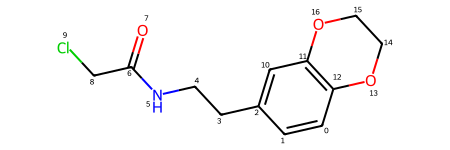

In [249]:
Chem.MolFromSmiles(df['smiles'][1])

In [250]:
df['smiles'] = df['smiles'].map(lambda smi: Chem.MolToSmiles(Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(run_rxn(Chem.AddHs(Chem.MolFromSmiles(smi)), '[Cl:2][#6:1][#6:3](=[#8:4])[#7:5]>>[*+:1][#6:3](=[#8:4])[#7:5].[*:2]')[0])))) if Chem.MolFromSmiles(smi).HasSubstructMatch(Chem.MolFromSmarts('[Cl:2][#6:1][#6:3](=[#8:4])[#7:5]')) else smi)

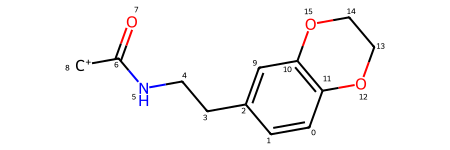

In [251]:
Chem.MolFromSmiles(df['smiles'][1])

In [252]:
# df.to_csv('../from_sources/covalentinhibtors_modifiedWarheadB.csv', index=False)

# Make regression plots for Figure 3

### Warhead A

OBS! Using pkl_files = glob.glob(f'submitit_results/covalentinhibtors/*result.pkl')

In [253]:
pkl_files = glob.glob(f'submitit_results/covalentinhibtors/*result.pkl')

calc_failed = []
df = pd.read_pickle(pkl_files[0])[-1]
for f in pkl_files[1:]:
    d = pd.read_pickle(f)
    if d[0] == 'error':
        calc_failed.append(f)
        continue
    df = df.append(d[-1], ignore_index=True, sort=False)

df = df[df['omega_transition_state'] > 0.0000]
print(df.shape[0])
df.head(2)

261


,smiles,name,Delta_G_ts,omega_ground_state,omega_transition_state,elec_sites,elec_names,elec_prod_smis,MAA_values,nuc_sites,nuc_names,nuc_prod_smis,MCA_values
1,[H]C([H])=C([H])C(=O)N([H])C([H])([H])c1snc([H...,ZINC000404465629,15.7257,0.9869,1.2359,"[[2, 0, 1, 3, 6, 8, 9, 10]]","[[Amide, Michael acceptor, double_bond, double...","[[C=CC(C)([O-])NCc1ccns1, CC[CH-]C(=O)NCc1ccns...","[[122.12033556494862, 201.91927520604804, 110....","[[3, 8, 0, 1, 2, 6, 9, 10, 4, 7]]","[[Amide, Pyridine_like_nitrogen, double_bond, ...","[[C=CC(=[NH+]Cc1ccns1)OC, C=CC(=O)NCc1cc[n+](C...","[[358.52686351770535, 418.0772583959624, 239.4..."
7,[H]C([H])=C([H])C(=O)N([H])C([H])([H])C([H])([...,ZINC000054137600,16.9506,0.9337,1.2200,"[[2, 0, 1, 3, 8, 9]]","[[Amide, Michael acceptor, double_bond, double...","[[C=CC(C)([O-])NCCCC#N, CC[CH-]C(=O)NCCCC#N, [...","[[92.0145496414043, 193.99849610147066, 105.14...","[[3, 9, 0, 1, 2, 8, 4]]","[[Amide, Nitrile, double_bond, double_bond, do...","[[C=CC(=[NH+]CCCC#N)OC, C=CC(=O)NCCCC#[N+]C, C...","[[363.8940910208039, 356.96428683772683, -inf,..."


In [254]:
Delta_G_ts_vals = []
omega_ground_state_vals = []
omega_transition_state_vals = []
MAA_vals = []
for idx, row in df.iterrows():
    
    smiles = row['smiles']
    name = str(row['name'])
    Delta_G_ts = row['Delta_G_ts']
    omega_ground_state = row['omega_ground_state']
    omega_transition_state = row['omega_transition_state']

    if name in ['107990248', '137505157', '130831123', '79384075', '131110412', '45240834', '61130698', '61297393', '57892468']:
        continue

    elec_sites = row.elec_sites[0]
    elec_names = row.elec_names[0]
    MAA_values = row.MAA_values[0]

    # display(Chem.MolFromSmiles(smiles))
    # print(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6]=[#6][#6](=[#8])[#7]"), uniquify=False)[0][0])
    
    index = elec_sites.index(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6]=[#6][#6](=[#8])[#7]"), uniquify=False)[0][0])
    elec_site = elec_sites[index]
    elec_name = elec_names[index]
    MAA_value = MAA_values[index]

    # print(elec_site, elec_name, MAA_value)
    # break

    if str(MAA_value) == '-inf':
        print(name)
        continue
    
    MAA_vals.append(MAA_value)
    Delta_G_ts_vals.append(Delta_G_ts)
    omega_ground_state_vals.append(omega_ground_state)
    omega_transition_state_vals.append(omega_transition_state)

ZINC000585086807
ZINC000216645802
ZINC000232395933


In [255]:
len(MAA_vals)

249

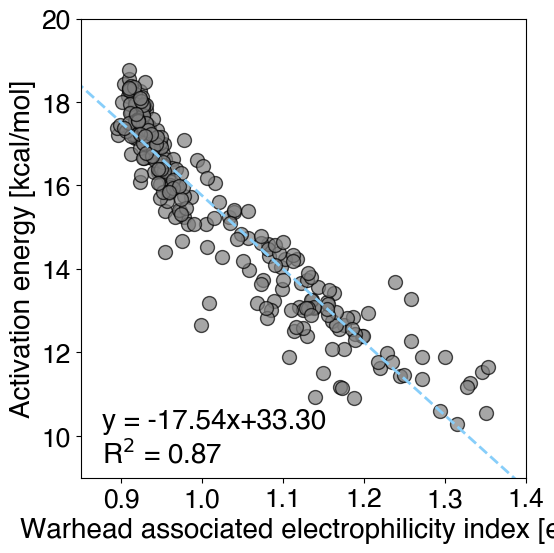

In [256]:
x = omega_ground_state_vals #omega_ground_state_vals
y = Delta_G_ts_vals

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('Warhead associated electrophilicity index [eV]', fontsize=20) #omega_ground_state_vals
plt.ylabel('Activation energy [kcal/mol]', fontsize=20)

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
plt.plot(np.arange(0,3,1), slope * np.arange(0,3,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2) #omega_ground_state_vals
plt.text(xmax-0.5, ymin-0.5, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20) #omega_ground_state_vals

plt.xlim(0.85,1.4) #omega_ground_state_vals
plt.ylim(9,20) #omega_ground_state_vals
plt.xticks(np.arange(0.9,1.45,0.1), fontsize=19) #omega_ground_state_vals
plt.yticks(np.arange(10,21,2), fontsize=19) #omega_ground_state_vals

plt.tight_layout()
plt.savefig('covalentinhibitos_A.pdf') 
plt.show()

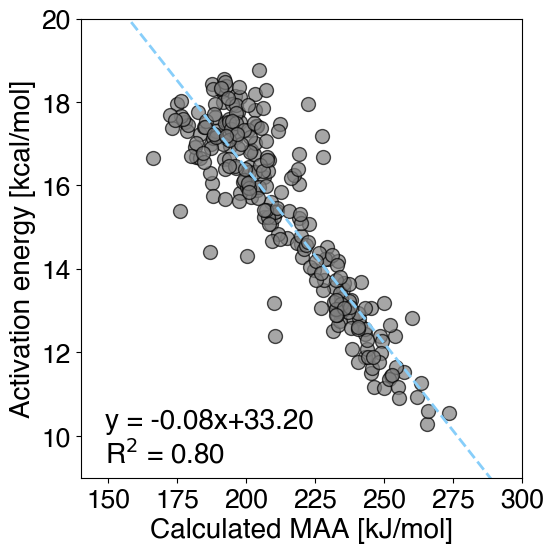

In [257]:
x = MAA_vals #MAA_vals
y = Delta_G_ts_vals

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('Calculated MAA [kJ/mol]', fontsize=20) #MAA_vals
plt.ylabel('Activation energy [kcal/mol]', fontsize=20)

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
plt.plot(np.arange(100,300,1), slope * np.arange(100,300,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2) #MAA_vals
plt.text(xmax-130, ymin-0.5, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20) #MAA_vals

plt.xlim(140,300) #MAA_vals
plt.ylim(9,20) #MAA_vals
plt.xticks(np.arange(150,301,25), fontsize=19) #MAA_vals
plt.yticks(np.arange(10,21,2), fontsize=19) #MAA_vals

plt.tight_layout()
plt.savefig('covalentinhibitos_A2.pdf') #MAA_vals
plt.show()

### Warhead C

OBS! Using pkl_files = glob.glob(f'submitit_results/covalentinhibtors/*result.pkl')

In [258]:
names_list = []
Delta_G_ts_vals = []
omega_ground_state_vals = []
omega_transition_state_vals = []
MAA_vals = []
for idx, row in df.iterrows():
    
    smiles = row['smiles']
    name = str(row['name'])
    Delta_G_ts = row['Delta_G_ts']
    omega_ground_state = row['omega_ground_state']
    omega_transition_state = row['omega_transition_state']

    if name not in ['107990248', '137505157', '130831123', '79384075', '131110412', '45240834', '61130698', '61297393', '57892468']:
        continue

    elec_sites = row.elec_sites[0]
    elec_names = row.elec_names[0]
    MAA_values = row.MAA_values[0]

    index = elec_sites.index(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6]#[#6][#6](=[#8])[#7]"), uniquify=False)[0][0])
    elec_site = elec_sites[index]
    elec_name = elec_names[index]
    MAA_value = MAA_values[index]

    if str(MAA_value) == '-inf':
        print(name)
        continue
    
    names_list.append(name)
    Delta_G_ts_vals.append(Delta_G_ts)
    omega_ground_state_vals.append(omega_ground_state)
    omega_transition_state_vals.append(omega_transition_state)
    MAA_vals.append(MAA_value)

In [259]:
len(MAA_vals)

9

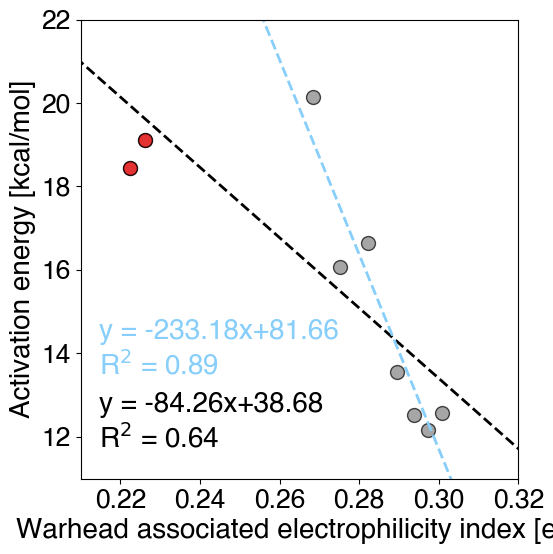

In [260]:
x = omega_ground_state_vals
y = Delta_G_ts_vals

x2 = [x[names_list.index('107990248')], x[names_list.index('137505157')]]
y2 = [y[names_list.index('107990248')], y[names_list.index('137505157')]]

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.scatter(x2, y2, marker='o', s=100, alpha=0.7, color='red', edgecolors='k')
plt.xlabel('Warhead associated electrophilicity index [eV]', fontsize=20) #omega_ground_state_vals
plt.ylabel('Activation energy [kcal/mol]', fontsize=20)

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
plt.plot(np.arange(-1,2,1), slope * np.arange(-1,2,1) + intercept, 'k', linestyle='dashed', lw=2) #omega_ground_state_vals
plt.text(xmax-0.09, ymin, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20) #omega_ground_state_vals

x3 = [n for n in x if n not in x2]
y3 = [n for n in y if n not in y2]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x3, y3)
plt.plot(np.arange(0,1,0.01), slope * np.arange(0,1,0.01) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2) #omega_ground_state_vals
plt.text(xmax-0.09, ymin+1.75, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='LightSkyBlue', fontsize=20) #omega_ground_state_vals

plt.xlim(0.21,0.32) #omega_ground_state_vals
plt.ylim(11,22) #omega_ground_state_vals
plt.xticks(np.arange(0.22,0.33,0.02), fontsize=19) #omega_ground_state_vals
plt.yticks(np.arange(12,23,2), fontsize=19) #omega_ground_state_vals


plt.tight_layout()
plt.savefig('covalentinhibitos_C.pdf') 
plt.show()

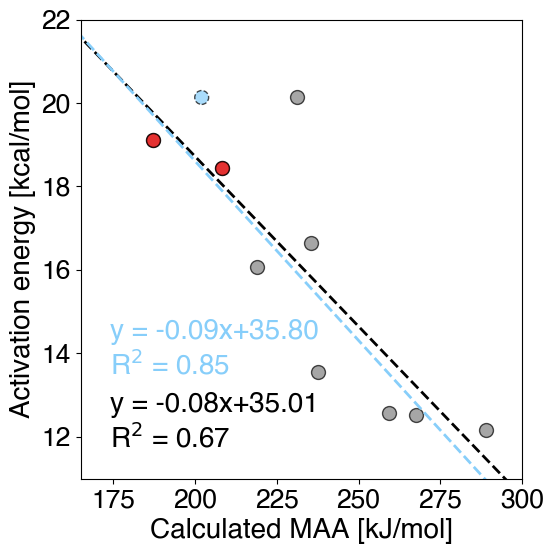

In [261]:
x = MAA_vals
y = Delta_G_ts_vals

x2 = [x[names_list.index('107990248')], x[names_list.index('137505157')]]
y2 = [y[names_list.index('107990248')], y[names_list.index('137505157')]]

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.scatter(x2, y2, marker='o', s=100, alpha=0.7, color='red', edgecolors='k')
plt.xlabel('Calculated MAA [kJ/mol]', fontsize=20)
plt.ylabel('Activation energy [kcal/mol]', fontsize=20)

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
plt.plot(np.arange(100,300,1), slope * np.arange(100,300,1) + intercept, 'k', linestyle='dashed', lw=2) #MAA_vals
plt.text(xmax-120, ymin, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20) #MAA_vals


x3 = copy.deepcopy(x)
x3[x.index(df[df['name'] == '61297393'].MAA_values.tolist()[0][0][df[df['name'] == '61297393'].elec_sites.tolist()[0][0].index(4)])] = df[df['name'] == '61297393'].MAA_values.tolist()[0][0][df[df['name'] == '61297393'].elec_sites.tolist()[0][0].index(5)]
y3 = copy.deepcopy(y)

index = x.index(df[df['name'] == '61297393'].MAA_values.tolist()[0][0][df[df['name'] == '61297393'].elec_sites.tolist()[0][0].index(4)])
plt.scatter(x3[index], y3[index], marker='o', s=100, alpha=0.7, color='LightSkyBlue', linestyle='dashed', edgecolors='k')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x3, y3)
plt.plot(np.arange(100,300,1), slope * np.arange(100,300,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)
plt.text(xmax-120, ymin+1.75, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='LightSkyBlue', fontsize=20)

plt.xlim(165,300) 
plt.ylim(11,22)
plt.xticks(np.arange(175,301,25), fontsize=19)
plt.yticks(np.arange(12,23,2), fontsize=19)

plt.tight_layout()
plt.savefig('covalentinhibitos_C2.pdf') 
plt.show()

[(0, 163.0895326794125), (1, 88.49515312723815), (2, 155.13897235901095), (3, 70.25014797737822), (6, 113.95002897270024), (7, 14.098986717639491), (4, 231.32324998476543), (5, 202.04613033519126)]


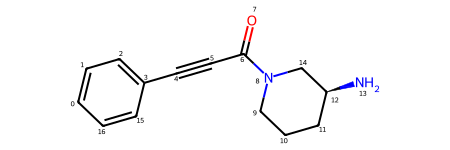

In [262]:
print(list(zip(df[df['name'] == '61297393'].elec_sites.tolist()[0][0], df[df['name'] == '61297393'].MAA_values.tolist()[0][0])))
Chem.MolFromSmiles(df[df['name'] == '61297393'].smiles.tolist()[0])

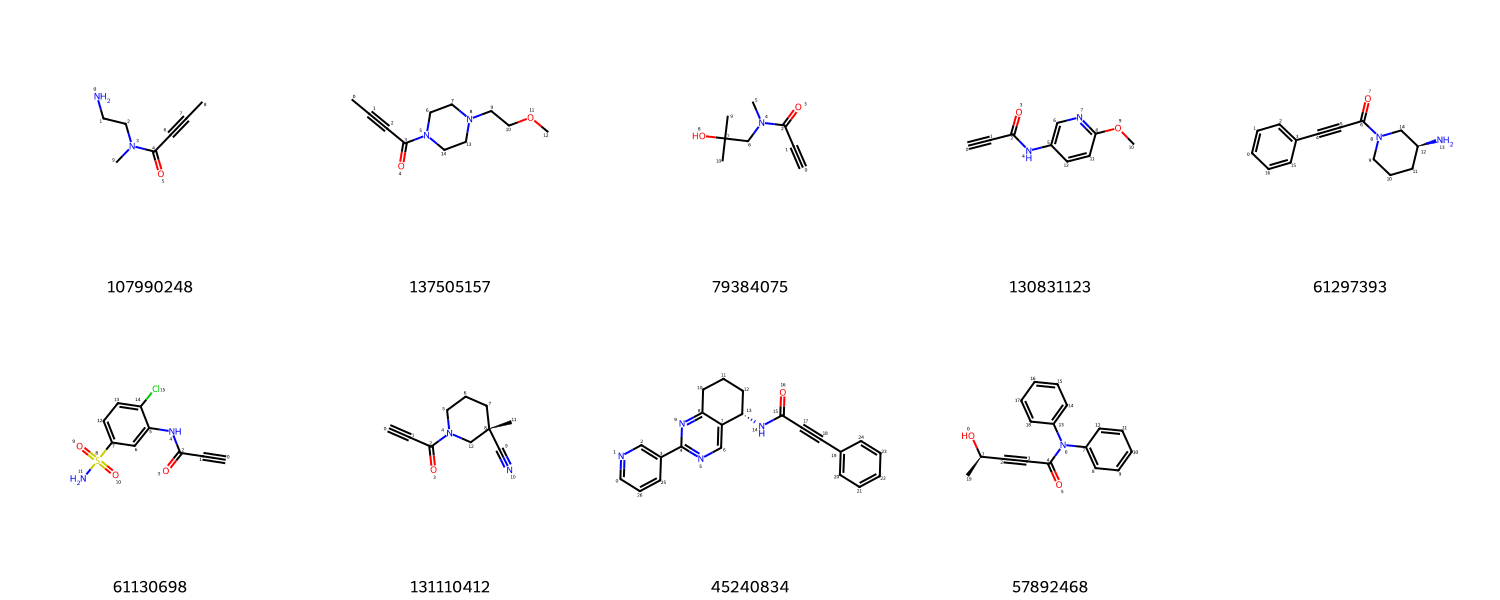

In [263]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in df[df['name'].isin(['107990248', '137505157', '130831123', '79384075', '131110412', '45240834', '61130698', '61297393', '57892468'])].smiles.tolist()], molsPerRow=5, subImgSize=(300,300), legends=df[df['name'].isin(['107990248', '137505157', '130831123', '79384075', '131110412', '45240834', '61130698', '61297393', '57892468'])]['name'].tolist())

### Warhead B

OBS! Using pkl_files = glob.glob(f'submitit_results/covalentinhibtors_modifiedWarheadB/*result.pkl')

In [264]:
pkl_files = glob.glob(f'submitit_results/covalentinhibtors_modifiedWarheadB/*result.pkl')

calc_failed = []
df = pd.read_pickle(pkl_files[0])[-1]
for f in pkl_files[1:]:
    d = pd.read_pickle(f)
    if d[0] == 'error':
        calc_failed.append(f)
        continue
    df = df.append(d[-1], ignore_index=True, sort=False)

In [265]:
Delta_G_ts_vals = []
omega_ground_state_vals = []
omega_transition_state_vals = []
MAA_vals = []
for idx, row in df.iterrows():

    if row['omega_transition_state'] != 0.0000:
        continue
    
    smiles = row['smiles']
    name = str(row['name'])
    Delta_G_ts = row['Delta_G_ts']
    omega_ground_state = row['omega_ground_state']
    omega_transition_state = row['omega_transition_state']

    # if name in ['107990248']:
    #     continue

    elec_sites = row.elec_sites[0]
    elec_names = row.elec_names[0]
    MAA_values = row.MAA_values[0]

    # display(Chem.MolFromSmiles(smiles))
    # print(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6+][#6](=[#8])[#7]"), uniquify=False)[0][0])
    
    index = elec_sites.index(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6+][#6](=[#8])[#7]"), uniquify=False)[0][0])
    elec_site = elec_sites[index]
    elec_name = elec_names[index]
    MAA_value = MAA_values[index]

    # print(elec_site, elec_name, MAA_value)
    # break

    if str(MAA_value) == '-inf':
        print(name)
        continue
    
    MAA_vals.append(MAA_value)
    Delta_G_ts_vals.append(Delta_G_ts)
    omega_ground_state_vals.append(omega_ground_state)
    omega_transition_state_vals.append(omega_transition_state)

ZINC000003324524
ZINC000042766562
ZINC000000519171
ZINC000040177559
ZINC000000236591
ZINC000004205434
ZINC000003882584
ZINC000101310978
ZINC000004205434
ZINC000101319089
ZINC000012524557
ZINC000057519827
ZINC000020217763
ZINC000003249591
ZINC000003886722
ZINC000009738185
ZINC000002510185
ZINC000000494769
ZINC000037654261
ZINC000003123715
ZINC000003269729


In [266]:
len(MAA_vals)

238

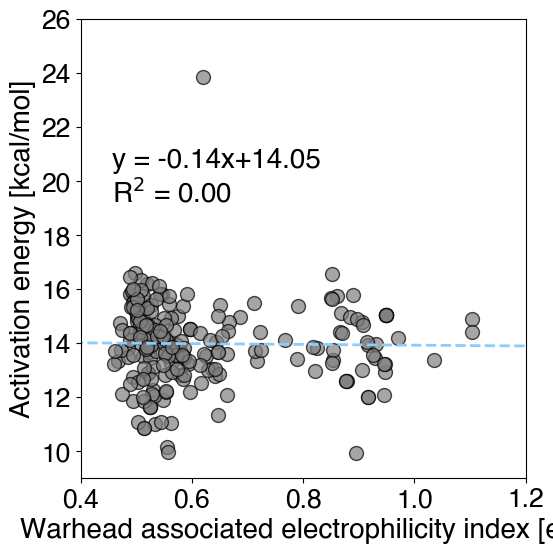

In [267]:
x = omega_ground_state_vals
y = Delta_G_ts_vals

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('Warhead associated electrophilicity index [eV]', fontsize=20) #omega_ground_state_vals
plt.ylabel('Activation energy [kcal/mol]', fontsize=20)

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
plt.plot(np.arange(0,3,1), slope * np.arange(0,3,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2) #omega_ground_state_vals

plt.text(xmax-0.68, ymin+10, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20) #omega_ground_state_vals

plt.xlim(0.4,1.2) #omega_ground_state_vals
plt.ylim(9,26) #omega_ground_state_vals
plt.xticks(np.arange(0.4,1.3,0.2), fontsize=19) #omega_ground_state_vals
plt.yticks(np.arange(10,28,2), fontsize=19) #omega_ground_state_vals

plt.tight_layout()
plt.savefig('covalentinhibitos_B.pdf')
plt.show()

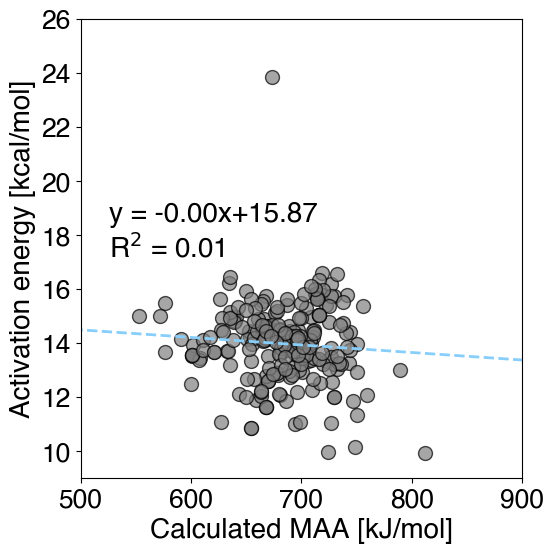

In [268]:
x = MAA_vals
y = Delta_G_ts_vals

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('Calculated MAA [kJ/mol]', fontsize=20) #MAA_vals
plt.ylabel('Activation energy [kcal/mol]', fontsize=20)

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
plt.plot(np.arange(400,1000,1), slope * np.arange(400,1000,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2) #MAA_vals

plt.text(xmax-300, ymin+8, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20) #MAA_vals

plt.xlim(500,900) #MAA_vals
plt.ylim(9,26) #MAA_vals
plt.xticks(np.arange(500,901,100), fontsize=19) #MAA_vals
plt.yticks(np.arange(10,28,2), fontsize=19) #MAA_vals

plt.tight_layout()
plt.savefig('covalentinhibitos_B2.pdf')
plt.show()

# Make regression plots for SMe results for SI

### Load data

In [269]:
pkl_files = glob.glob(f'submitit_results/covalentinhibtors_SMe/*result.pkl')

calc_failed = []
df = pd.read_pickle(pkl_files[0])[-1]
for f in pkl_files[1:]:
    d = pd.read_pickle(f)
    if d[0] == 'error':
        calc_failed.append(f)
        continue
    df = df.append(d[-1], ignore_index=True, sort=False)

print(df.shape[0])
df.head(2)

520


,smiles,name,Delta_G_ts,omega_ground_state,omega_transition_state,elec_sites,elec_names,elec_prod_smis,MAA_values,nuc_sites,nuc_names,nuc_prod_smis,MCA_values
0,[H]C([H])=C([H])C(=O)N(C([H])([H])C(=O)N([H])[...,ZINC000328598346,16.9279,0.9499,1.203,"[[2, 6, 0, 1, 3, 7]]","[[Amide, Amide, Michael acceptor, double_bond,...","[[C=CC([O-])(SC)N(CCC1CCCCC1)CC(N)=O, C=CC(=O)...","[[1045534.7143387534, 1045558.984705626, 10456...","[[3, 7, 0, 1, 2, 6, 4, 8]]","[[Amide, Amide, double_bond, double_bond, doub...","[[C=CC(OSC)=[N+](CCC1CCCCC1)CC(N)=O, C=CC(=O)N...","[[1045674.6356474105, 1045699.5140168197, 1045..."
1,[H][C+]([H])C(=O)N1C([H])([H])C([H])([H])C([H]...,ZINC000061918680,13.5951,0.6624,0.000,"[[0, 1, 2]]","[[Carbocation, double_bond, double_bond]]","[[CSCC(=O)N1CCCOC(C)C1, [CH2+]C([O-])(SC)N1CCC...","[[1046069.3032025683, -inf, 1045874.5169480217]]","[[7, 1, 2, 3]]","[[Ether, double_bond, atom_with_lone_pair, ato...","[[[CH2+]C(=O)N1CCC[O+](SC)C(C)C1, [CH2+]C([O+]...","[[1045617.9152253985, -inf, 1045684.4073421245..."


### Warhead A (SMe)

In [279]:
Delta_G_ts_vals = []
omega_ground_state_vals = []
omega_transition_state_vals = []
MAA_vals = []
for idx, row in df.iterrows():
    
    smiles = row['smiles']
    name = str(row['name'])
    Delta_G_ts = row['Delta_G_ts']
    omega_ground_state = row['omega_ground_state']
    omega_transition_state = row['omega_transition_state']

    if not omega_transition_state > 0.0000:
        continue

    if name in ['107990248', '137505157', '130831123', '79384075', '131110412', '45240834', '61130698', '61297393', '57892468']:
        continue

    elec_sites = row.elec_sites[0]
    elec_names = row.elec_names[0]
    MAA_values = row.MAA_values[0]

    # display(Chem.MolFromSmiles(smiles))
    # print(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6]=[#6][#6](=[#8])[#7]"), uniquify=False)[0][0])
    
    index = elec_sites.index(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6]=[#6][#6](=[#8])[#7]"), uniquify=False)[0][0])
    elec_site = elec_sites[index]
    elec_name = elec_names[index]
    MAA_value = MAA_values[index]

    # print(elec_site, elec_name, MAA_value)
    # break

    if str(MAA_value) == '-inf':
        print(name)
        continue
    
    MAA_vals.append(MAA_value)
    Delta_G_ts_vals.append(Delta_G_ts)
    omega_ground_state_vals.append(omega_ground_state)
    omega_transition_state_vals.append(omega_transition_state)

ZINC000216645802
ZINC000232395933
ZINC000585086807


In [280]:
len(MAA_vals)

256

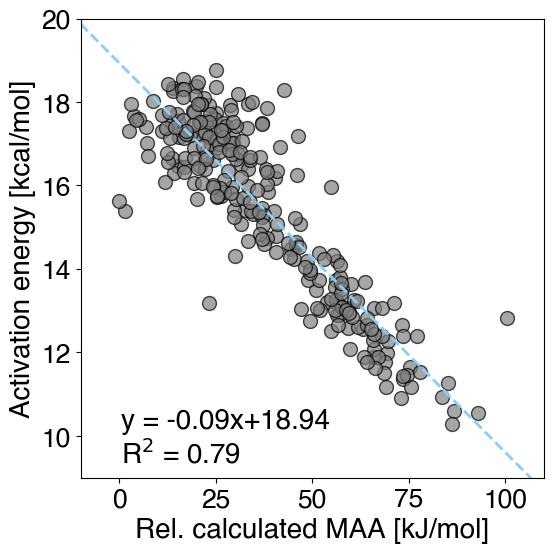

In [281]:
x = np.array(MAA_vals) - min(MAA_vals) #SME
y = Delta_G_ts_vals

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('Rel. calculated MAA [kJ/mol]', fontsize=20) #SME
plt.ylabel('Activation energy [kcal/mol]', fontsize=20)

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
plt.plot(np.arange(-10,110,1), slope * np.arange(-10,110,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2) #SME
plt.text(xmax-105, ymin-0.5, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20) #SME

plt.xlim(-10,110) #SME
plt.ylim(9,20) #SME
plt.xticks(np.arange(0,111,25), fontsize=19) #SME
plt.yticks(np.arange(10,21,2), fontsize=19) #SME

plt.tight_layout()
plt.savefig('covalentinhibitos_A2_SMe.pdf') #SME
plt.show()

### Warhead C (SMe)

In [273]:
names_list = []
Delta_G_ts_vals = []
omega_ground_state_vals = []
omega_transition_state_vals = []
MAA_vals = []
for idx, row in df.iterrows():
    
    smiles = row['smiles']
    name = str(row['name'])
    Delta_G_ts = row['Delta_G_ts']
    omega_ground_state = row['omega_ground_state']
    omega_transition_state = row['omega_transition_state']

    if name not in ['107990248', '137505157', '130831123', '79384075', '131110412', '45240834', '61130698', '61297393', '57892468']:
        continue

    elec_sites = row.elec_sites[0]
    elec_names = row.elec_names[0]
    MAA_values = row.MAA_values[0]

    index = elec_sites.index(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6]#[#6][#6](=[#8])[#7]"), uniquify=False)[0][0])
    elec_site = elec_sites[index]
    elec_name = elec_names[index]
    MAA_value = MAA_values[index]

    if str(MAA_value) == '-inf':
        print(name)
        continue
    
    names_list.append(name)
    Delta_G_ts_vals.append(Delta_G_ts)
    omega_ground_state_vals.append(omega_ground_state)
    omega_transition_state_vals.append(omega_transition_state)
    MAA_vals.append(MAA_value)

In [274]:
len(MAA_vals)

9

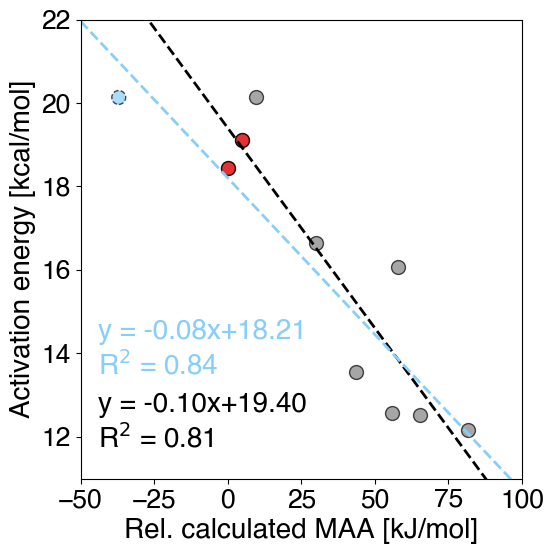

In [275]:
x = list(np.array(MAA_vals) - min(MAA_vals)) #SMe
y = Delta_G_ts_vals

x2 = [x[names_list.index('107990248')], x[names_list.index('137505157')]]
y2 = [y[names_list.index('107990248')], y[names_list.index('137505157')]]

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.scatter(x2, y2, marker='o', s=100, alpha=0.7, color='red', edgecolors='k')
plt.xlabel('Rel. calculated MAA [kJ/mol]', fontsize=20) #SMe
plt.ylabel('Activation energy [kcal/mol]', fontsize=20)

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
plt.plot(np.arange(-50,100,1), slope * np.arange(-50,100,1) + intercept, 'k', linestyle='dashed', lw=2) #SMe
plt.text(xmax-130, ymin, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20) #SMe


x3 = copy.deepcopy(x)
x3[df[df['name'] == '61297393'].elec_sites.tolist()[0][0].index(4)] = df[df['name'] == '61297393'].MAA_values.tolist()[0][0][df[df['name'] == '61297393'].elec_sites.tolist()[0][0].index(5)] - min(MAA_vals)
y3 = copy.deepcopy(y)

index = df[df['name'] == '61297393'].elec_sites.tolist()[0][0].index(4)
plt.scatter(x3[index], y3[index], marker='o', s=100, alpha=0.7, color='LightSkyBlue', linestyle='dashed', edgecolors='k')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x3, y3)
plt.plot(np.arange(-50,100,1), slope * np.arange(-50,100,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)
plt.text(xmax-130, ymin+1.75, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='LightSkyBlue', fontsize=20)

plt.xlim(-50,100) #SME
plt.ylim(11,22) #SME
plt.xticks(np.arange(-50,101,25), fontsize=19) #SME
plt.yticks(np.arange(12,23,2), fontsize=19) #SME

plt.tight_layout()
plt.savefig('covalentinhibitos_C2_SMe.pdf') 
plt.show()

### Warhead B (SMe)

In [276]:
Delta_G_ts_vals = []
omega_ground_state_vals = []
omega_transition_state_vals = []
MAA_vals = []
for idx, row in df.iterrows():

    if row['omega_transition_state'] != 0.0000:
        continue
    
    smiles = row['smiles']
    name = str(row['name'])
    Delta_G_ts = row['Delta_G_ts']
    omega_ground_state = row['omega_ground_state']
    omega_transition_state = row['omega_transition_state']

    # if name in ['107990248']:
    #     continue

    elec_sites = row.elec_sites[0]
    elec_names = row.elec_names[0]
    MAA_values = row.MAA_values[0]

    # display(Chem.MolFromSmiles(smiles))
    # print(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6+][#6](=[#8])[#7]"), uniquify=False)[0][0])
    
    index = elec_sites.index(Chem.MolFromSmiles(smiles).GetSubstructMatches(Chem.MolFromSmarts("[#6+][#6](=[#8])[#7]"), uniquify=False)[0][0])
    elec_site = elec_sites[index]
    elec_name = elec_names[index]
    MAA_value = MAA_values[index]

    # print(elec_site, elec_name, MAA_value)
    # break

    if str(MAA_value) == '-inf':
        print(name)
        continue
    
    MAA_vals.append(MAA_value)
    Delta_G_ts_vals.append(Delta_G_ts)
    omega_ground_state_vals.append(omega_ground_state)
    omega_transition_state_vals.append(omega_transition_state)

ZINC000003882584
ZINC000101310978
ZINC000000078250
ZINC000004205434
ZINC000004205434
ZINC000004411382
ZINC000040494237
ZINC000000236591
ZINC000040177559
ZINC000000519171
ZINC000000161544
ZINC000003324524
ZINC000042766562
ZINC000003269729
ZINC000003123715
ZINC000037654261
ZINC000036905951
ZINC000000494769
ZINC000002510185
ZINC000012524557
ZINC000009738185
ZINC000057519827
ZINC000003886722
ZINC000003249591
ZINC000002522979


In [277]:
len(MAA_vals)

227

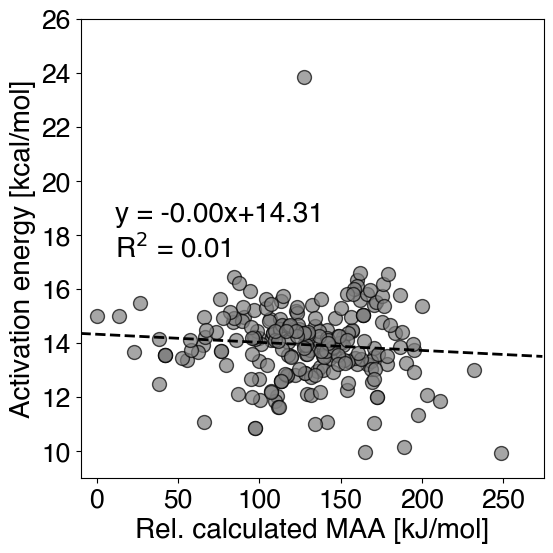

In [278]:
x = list(np.array(MAA_vals) - min(MAA_vals)) #SMe
y = Delta_G_ts_vals

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('Rel. calculated MAA [kJ/mol]', fontsize=20) #SMe
plt.ylabel('Activation energy [kcal/mol]', fontsize=20)

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
plt.plot(np.arange(-10,275,1), slope * np.arange(-10,275,1) + intercept, 'k', linestyle='dashed', lw=2) #SMe
plt.text(xmax-250, ymin+8, f"y = {slope:.2f}x+{intercept:.2f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20) #SMe

plt.xlim(-10,275) #MAA_vals
plt.ylim(9,26) #MAA_vals
plt.xticks(np.arange(0,275,50), fontsize=19) #MAA_vals
plt.yticks(np.arange(10,28,2), fontsize=19) #MAA_vals

plt.tight_layout()
plt.savefig('covalentinhibitos_B2_SMe.pdf')
plt.show()